# Global Black Box Optimization with RNNS
Project by Pattarawat Chormai and Felix Sattler ||
Supervised by Raphael Holca-Lamarre

In [1]:
# Imports
import tensorflow as tf
import numpy as np
import visualize as viz
import benchmarkfunctions as bf
import gpfunctions as gp
import lstm_model
import data

## Set all the Hyperparameters

In [2]:
# Data
load_data = False
save_data = False
dim = 2
n_train = 1600
n_test = 160
n_bumps = 4
l = 2/n_bumps*np.sqrt(dim)
n_mc_samples = 1000
max_x_abs_value = 1.0
kernel = gp.matern32_kernel
function = gp.normalized_gp_function

# LSTM Model
n_hidden = 100
n_steps = 20

# Optimization
x_start = np.zeros(dim).reshape(1,dim)
epochs = 400
gradient_clipping = 1.0
forget_bias = 5.0
rate_init = 0.005
rate_final = 0.0001
rate_decay = (rate_final/rate_init)**(1/epochs)
batch_size = 128
stddev = 0.00
loss_type = ["MIN", "SUM", "WSUM", "OI", "OI_UPDATED", "SUMIN", "WSUM_EXPO"][4]

# Visualization
visualize = True

## Create Training Data or load from Disk

In [3]:
# Create Data or Load Data from Disk
if load_data:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = data.load_data
else:
    X_train, A_train, min_train, max_train, X_test, A_test, min_test, max_test = \
                                    data.gen_data(n_train, n_test, dim, n_bumps, l, kernel, n_mc_samples)
# Save Data to Disk
if save_data:
    save_data(n_train, n_test, dim, n_bumps, l, n_mc_samples = 100)
        
data_train = (X_train, A_train, min_train, max_train)
data_test = (X_test, A_test, min_test, max_test)

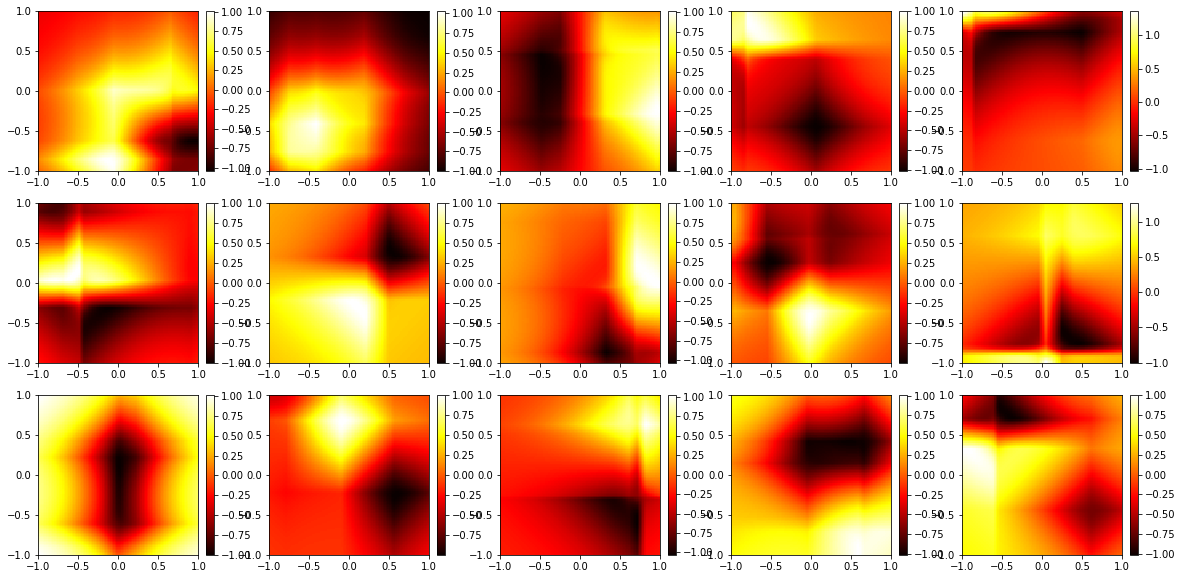

In [4]:
# Visualize Training Data
if visualize: viz.plot_gp_data_sample(15, X_train, A_train, min_train, max_train, l, kernel, function)

## Build the Training Graph

In [5]:
# Build the training graph, collect placeholders, sample sequence and lstmcell parameters 
Xt, At, mint, maxt, samples_x, samples_y, x_0, cell, weights = \
    lstm_model.build_training_graph(n_bumps, dim, n_hidden, forget_bias, n_steps, l, kernel, function)
placeholders = {"Xt": Xt, "At": At, "mint": mint, "maxt": maxt, "x0": x_0}

## Start a Session and start training

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [7]:
train_logs = lstm_model.train_model(sess, placeholders, samples_x, samples_y, epochs, batch_size, data_train, data_test,
                     rate_init, rate_decay, gradient_clipping, loss_type, x_start, max_x_abs_value, log = True)

Ep:    0 | TrainLoss: -0.099 | TrainMin: -0.398 | TestLoss: -0.190 | TestMin: -0.439
Ep:    1 | TrainLoss: -0.344 | TrainMin: -0.648 | TestLoss: -0.384 | TestMin: -0.670
Ep:    2 | TrainLoss: -0.661 | TrainMin: -0.664 | TestLoss: -0.674 | TestMin: -0.690
Ep:    3 | TrainLoss: -0.612 | TrainMin: -0.625 | TestLoss: -0.589 | TestMin: -0.611
Ep:    4 | TrainLoss: -0.623 | TrainMin: -0.661 | TestLoss: -0.605 | TestMin: -0.652
Ep:    5 | TrainLoss: -0.628 | TrainMin: -0.631 | TestLoss: -0.627 | TestMin: -0.643
Ep:    6 | TrainLoss: -0.682 | TrainMin: -0.689 | TestLoss: -0.677 | TestMin: -0.697
Ep:    7 | TrainLoss: -0.701 | TrainMin: -0.704 | TestLoss: -0.702 | TestMin: -0.718
Ep:    8 | TrainLoss: -0.698 | TrainMin: -0.701 | TestLoss: -0.698 | TestMin: -0.714
Ep:    9 | TrainLoss: -0.686 | TrainMin: -0.714 | TestLoss: -0.702 | TestMin: -0.740
Ep:   40 | TrainLoss: -0.728 | TrainMin: -0.734 | TestLoss: -0.721 | TestMin: -0.738
Ep:   80 | TrainLoss: -0.857 | TrainMin: -0.860 | TestLoss: -0.83

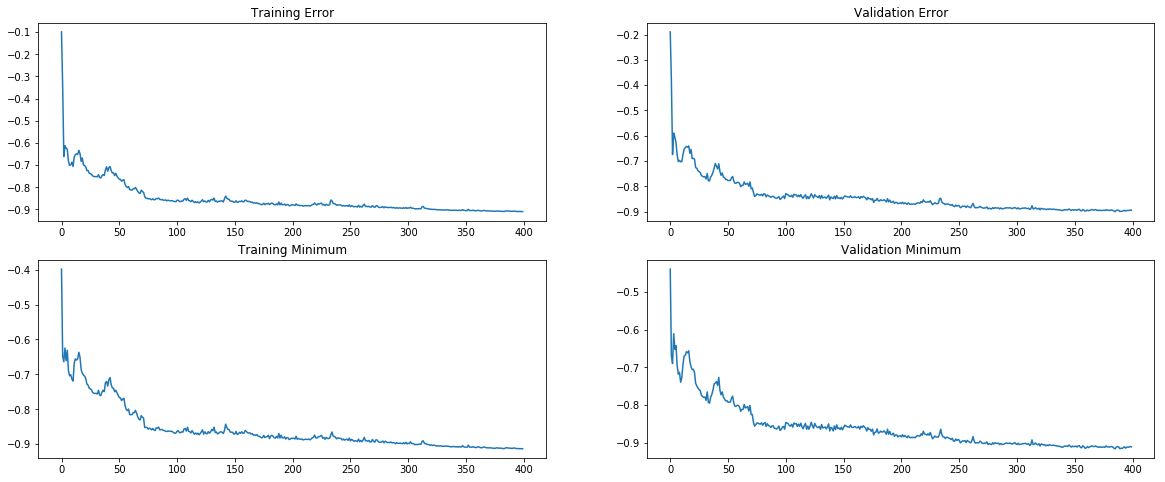

In [8]:
viz.visualize_learning(train_logs)

## Evaluate the Model on Training Data

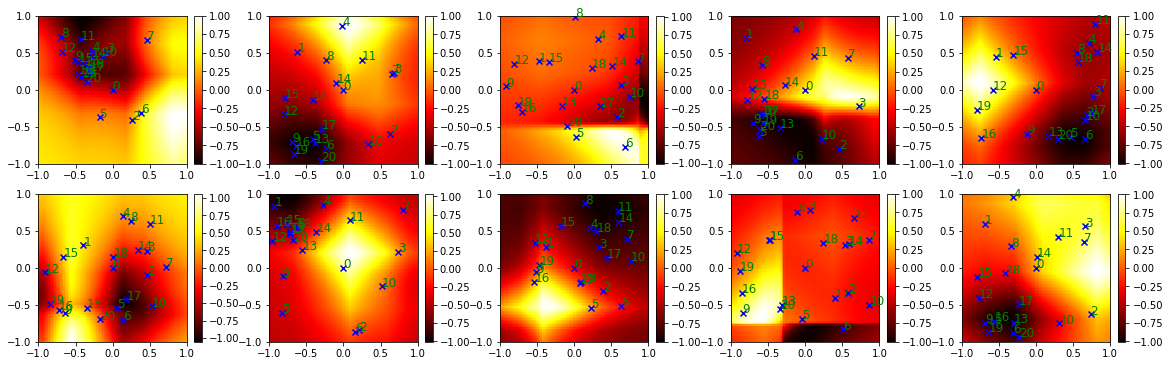

In [9]:
# Show results on Training Data
samples_train_x, samples_train_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_train, x_start)
    
viz.plot_gp_results_sample(10, X_train, A_train, min_train, max_train, l, samples_train_x, samples_train_y, kernel, function)

## Evaluate the Model on Test Data

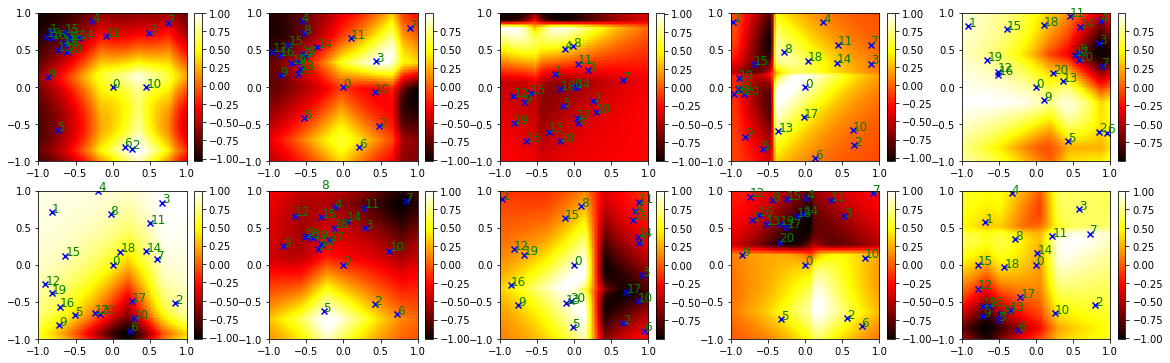

In [10]:
# Show results on Test Data
samples_test_x, samples_test_y = \
        lstm_model.get_samples(sess, placeholders, samples_x, samples_y, data_test, x_start)

viz.plot_gp_results_sample(10, X_test, A_test, min_test, max_test, l, samples_test_x, samples_test_y, kernel, function)

## Evaluate the Model on Benchmark Functions

In [11]:
f_bm = [bf.branin, bf.goldstein_price, bf.hartmann3, bf.hartmann6][0]
f_bm_tf = [bf.branin_tf, bf.goldstein_price_tf, bf.hartmann3_tf, bf.hartmann6_tf][0]

In [12]:
samples_benchmark_x, samples_benchmark_y = \
        lstm_model.get_benchmark_samples(sess, f_bm_tf, cell, weights, dim, n_hidden, n_steps, x_start)

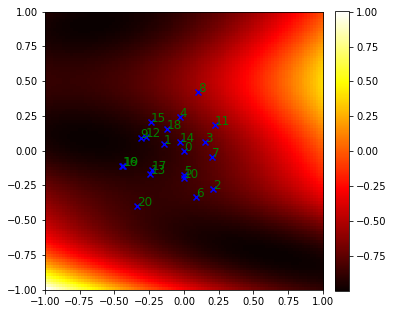

In [13]:
viz.plot_result(f_bm, dim, 1, samples_benchmark_x, samples_benchmark_y)